## Haplotype validation

Haplotype validation based on parent/progeny and synthetic X as a gold standard.

Recent updates:
- Read in raw phased data and draw bar plots from those.

In [1]:
%run setup.ipynb 

In [2]:
rcParams['text.usetex'] = False

In [3]:
from pathlib import Path
from matplotlib.ticker import FuncFormatter

In [4]:
def fposition(x, pos):
    'The two args are the value and tick position'
    return '%2d' % (x*1e-6)

In [5]:
autosomes = "2R", "2L", "3R", "3L"

In [6]:
meta_fn = Path(phase2_ar1.samples_dir) / "cross.samples.meta.txt"
meta_info = pandas.read_csv(meta_fn, sep="\t", index_col=0).set_index("ox_code")
meta_info.head()

,cross,role,n_reads,median_cov,mean_cov,sex,colony_id
ox_code,,,,,,,
AD0142-C,18-5,parent,60486753,26,25.824447,F,Ghana
AD0143-C,18-5,parent,58509103,19,18.800118,M,Kisumu/G3
AD0146-C,18-5,progeny,101612499,44,43.494594,NaN,NaN
AD0147-C,18-5,progeny,50710020,16,16.284487,NaN,NaN
AD0148-C,18-5,progeny,59023991,19,18.978021,NaN,NaN


In [7]:
meta_info.groupby(["cross", "role"]).size()

cross  role   
18-5   parent      2
       progeny    20
29-2   parent      2
       progeny    20
36-9   parent      2
       progeny    20
37-3   parent      2
       progeny    20
42-4   parent      2
       progeny    14
45-1   parent      2
       progeny    20
46-9   parent      2
       progeny    20
47-6   parent      2
       progeny    20
73-2   parent      2
       progeny    19
78-2   parent      2
       progeny    19
80-2   parent      2
       progeny    20
dtype: int64

In [8]:
# mem = memory.Memory(cachedir="/tmp")

In [9]:
# ihnfstem = os.path.join("/data/coluzzi/ag1000g/data/phase1/release/AR3.1",
#                         "haplotypes/crosses/hdf5",
#                         "{chrom}_{cross}_{parent}_inheritance")

In [10]:
callset_dir = Path(phase2_ar1.haplotypes_dir) / "crosses/zarr2"
callset_path = callset_dir / "ag1000g.crosses.phase2.ar1.haplotypes.zip"

In [11]:
stor = zarr.ZipStore(callset_path, mode="r")
callset = zarr.Group(stor)

## Phase 1 overload

In [15]:
# path = Path("/kwiat/./vector/ag1000g/analysis/20170508-phase2-AR1-gt-crosses/phase2.AR1-parents-progeny/output")

# zz["phased_genotypes"]

# zb["phased_genotypes"]

# positions["3L"]

In [16]:
# # meta_fn = Path(phase1_ar31.samples_dir) / "cross.samples.meta.txt"
# meta_info = pandas.read_csv(
#     "/kwiat/vector/ag1000g/release/phase1.AR3.1/samples/cross.samples.meta.txt", 
#     sep="\t", index_col=0)



# hapstem = os.path.join(
#     "/kwiat/vector/ag1000g/release/phase1.AR3/haplotypes/crosses/hdf5",
#     "ag1000g.crosses.phase1.ar3.haplotypes.{chrom}.h5")

# hapstem

# callset = {c: h5py.File(hapstem.format(chrom=c), mode="r")[c] for c in autosomes}

# h5py.File(hapstem.format(chrom="3L"))["3L"]

In [14]:
xgp = meta_info.groupby("cross")

In [15]:
def plot_transmission(painting, ax=None, title=None, palette_name='colorblind'):

    palette = sns.color_palette(palette_name)

    # set figure height depending on number of haplotypes

    # map painting codes onto colours
    cmap = mpl.colors.ListedColormap([
        'white',      # 0 = undetermined
        palette[0],  # 1 = allele inherited from first parental haplotype
        palette[2],  # 2 = allele inherited from second parental haplotype
        'lightgrey',     # 3 = reference allele, also carried by both parental haplotypes
        'lightgrey',     # 4 = non-reference allele, also carried by both parental haplotypes
        'black',     # 5 = non-parental allele (i.e., Mendelian error)
        palette[5],  # 6 = either or both parental alleles missing
        'white',     # 7 = missing allele
    ])

    # plot painting
    ax.pcolormesh(painting.T, cmap=cmap, vmin=0, vmax=7)

    # tidy up axes
    ax.set_yticks(np.arange(painting.shape[1]) + .5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     ax.set_ylabel('Progeny haplotypes')
#     ax.set_xlabel('Variants')
    if title:
        ax.set_title(title)

In [16]:
xid = "29-2"

In [17]:
genome = phase2_ar1.genome_agamp3

In [18]:
path = Path(
    "/kwiat/vector/ag1000g/analysis",
    "20170508-phase2-AR1-gt-crosses/phase2.AR1-parents-progeny", "output")

In [ ]:
path

In [20]:
gs = GridSpec(
        3, len(autosomes), 
        height_ratios=(1, 1, 0.3),
        width_ratios=[len(genome[k]) for k in autosomes], 
        wspace=0.1, hspace=0.1)

In [21]:
np.savez_compressed("/tmp/npf.npz", x=np.random.random(1000))

In [24]:
cache_fn

PosixPath('/tmp/2R/47-6/Maternal.npz')

In [26]:
for xid in meta_info.cross.unique():
    
    fig = plt.figure(figsize=(12, 5))
    plotfn =  Path("../artwork", "haplotype-validation",
                   "allele_transmission_{xid}.png".format(xid=xid))
    
    if plotfn.is_file():
        continue

    for i, chrom in enumerate(autosomes):
    #for i, chrom in enumerate(["3L"]):

        zarrfn = path / chrom / (xid + ".zarr2")
        zz = zarr.open_group(zarrfn.as_posix(), mode="r")
        phased_genotypes = allel.GenotypeChunkedArray(zz["phased_genotypes"])
        pos = allel.SortedIndex(zz["POS"])

        het_loci = allel.GenotypeArray(phased_genotypes).is_het().any(axis=1)
        phased_genotypes = phased_genotypes.compress(het_loci, axis=0)

        haplotypes_progeny = allel.GenotypeArray(phased_genotypes[:, 2:, :])
        pos = pos.compress(het_loci)

        for ix, parent_label in enumerate(["Maternal", "Paternal"]):

            ax = fig.add_subplot(gs[ix, i])

            cache_fn = Path("/tmp", "-".join([chrom, xid, parent_label + ".npz"]))

            if cache_fn.is_file():
                painting = np.load(cache_fn)["painting"]
            
            else:
                # pull out mother's genotypes from the first column
                genotypes_parent = phased_genotypes[:, ix]

                # convert to haplotype array
                haplotypes_parent = genotypes_parent.to_haplotypes()

                # pull out maternal haplotypes from the progeny
                haplotypes_progeny_given_parent = haplotypes_progeny[:, :, ix]

                painting = allel.paint_transmission(
                    haplotypes_parent, haplotypes_progeny_given_parent)
                
                np.savez_compressed(cache_fn, painting=painting)

            
            # skip every 5 rows.
            plot_transmission(painting[::2], ax=ax)
            ax.tick_params(direction='out', length=1, width=1)

            if i == 0:
                ax.set_ylabel(parent_label)

        ax = fig.add_subplot(gs[2, i])
        allel.plot_variant_locator(pos, ax=ax)
        _ = ax.set_xticks(np.arange(0, len(genome[chrom]), 1e7))
        ax.xaxis.set_ticks_position("bottom")
        formatter = FuncFormatter(fposition)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel(chrom)

    _ = fig.text(0.5, 0.03, 'Genomic position (Mbp)', ha='center', va='top')
    _ = fig.suptitle("Haplotype transmission for {xid}".format(xid=xid))

    fig.savefig(
        plotfn,
        dpi=300,
        bbox_inches='tight')
    
    plt.close()

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

## Panel B

In [31]:
from intervaltree import IntervalTree
import pyfasta

In [34]:
import re
def find_reference_gaps(genome_fa, gap_size=300):

    # fix on a gapsize of 1kb, as ld breaks down over this distance and
    # do chunks of 10k at a time. look for consecutive Ns.
    size = 10000
    gaps = list()
    
    match = "N{{{n}}}?".format(n=gap_size)
    
    for i in range(0, len(genome_fa), size - (2 * gap_size)):
        text = genome_fa[i:i+size]

        for m in re.finditer(match, text, flags=re.IGNORECASE):
            gaps.append((i + m.start(), i + m.end()))

    tree = IntervalTree.from_tuples(gaps)
    tree.merge_overlaps()

    return np.array([[iv.begin, iv.end] for iv in sorted(tree)])

In [52]:
# load data from data release

In [83]:
eval_path = Path(
    "/kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes")

In [88]:
frame_d = {
    chrom: eval_path / "eval_autosomal_phasing/output/{chrom}_table_switch_errors.txt".format(chrom=chrom)
    for chrom in autosomes}

frame_d["X"] = eval_path / "eval_x_phasing/output/X_table_switch_errors.txt"

In [91]:
for k, v in frame_d.items():
    print(k, v.absolute(), v.is_file())   

2R /kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes/eval_autosomal_phasing/output/2R_table_switch_errors.txt True
2L /kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes/eval_autosomal_phasing/output/2L_table_switch_errors.txt True
3R /kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes/eval_autosomal_phasing/output/3R_table_switch_errors.txt True
3L /kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes/eval_autosomal_phasing/output/3L_table_switch_errors.txt True
X /kwiat/vector/ag1000g/analysis/20170316-phase2-haplotypes/eval_x_phasing/output/X_table_switch_errors.txt True


In [92]:
def draw_msd_across_genome(genome_pos, marker_dist, mean_switch_dist, number_markers, chrom, ax):

    mean_switch_dist[number_markers < 50] = np.NaN
        
    ax.plot(genome_pos, 2 * marker_dist, 'k-', linewidth=1.0)
    ax.plot(genome_pos, mean_switch_dist, 'r-',  linewidth=1.0)

    ax.grid(True)
    
    ax.set_yscale("log")
    ax.set_ylim((100, 2000000))
    ax.set_xlim((0, len(genome[chrom])))
    
    _ = ax.set_xticks(np.arange(0, len(genome[chrom]), 1e7))

    return ax

In [93]:
def draw_switch_err_rate(genome_pos, rate, number_markers, chrom, ax):

    rate[number_markers < 50] = np.NaN   
    ax.plot(genome_pos, 1 - rate, 'r-', linewidth=1.0)

    ax.grid(True)
    ax.set_ylim((0.82, 1.0))
    ax.set_xlim((0, len(genome[chrom])))
    
    _ = ax.set_xticks(np.arange(0, len(genome[chrom]), 1e7))
    formatter = FuncFormatter(fposition)
    ax.xaxis.set_major_formatter(formatter)

    return ax

('2R', '2L', '3R', '3L', 'X')

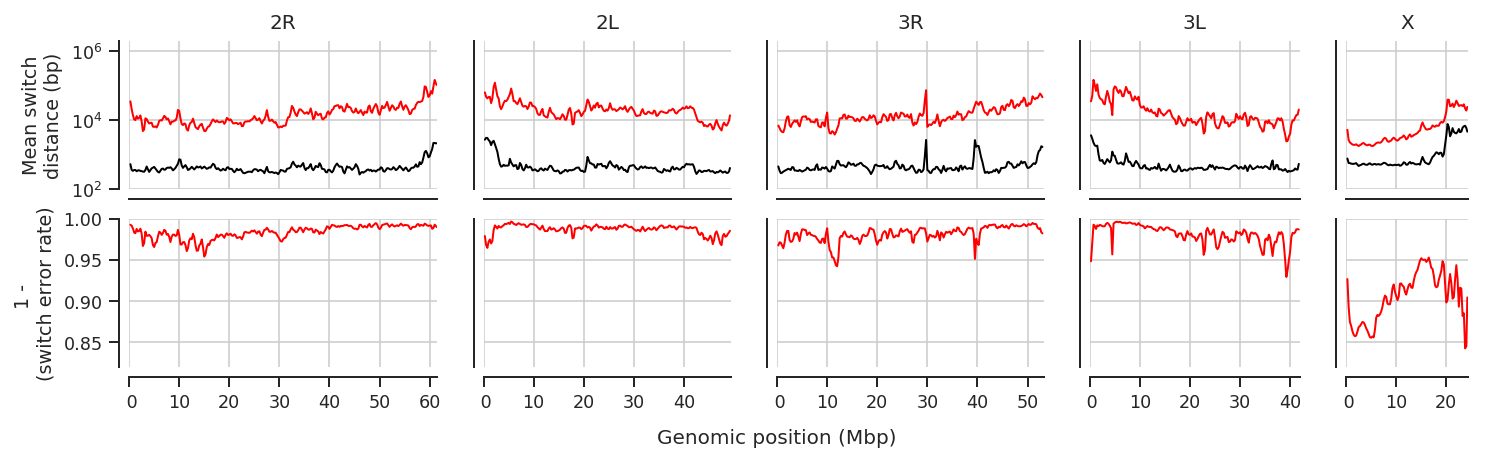

In [97]:
contigs = chromosomes[:5]


gs = GridSpec(
    2, len(contigs), 
    width_ratios=[len(genome[k]) for k in contigs], 
    wspace=0.2)

fig = plt.figure(figsize=(12, 3))

for i, chrom in enumerate(contigs):

    df = pandas.read_csv(frame_d[chrom], sep="\t")

    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i])
    sns.despine(ax=ax1, offset=5)
    sns.despine(ax=ax2, offset=5)

    pos = 0.5 * np.array(df.start + df.stop)
    mean_marker_d = np.array(df.mean_marker_dist)
    mean_switch_d = np.array(df.mean_switch_dist)

    n_markers = np.array(df.n_markers)
    err_rate = np.array(df.err_rate)

    draw_msd_across_genome(pos, mean_marker_d, mean_switch_d, n_markers, chrom, ax1)
    draw_switch_err_rate(pos, err_rate, n_markers, chrom, ax2)

    if i == 0:
        ax1.set_ylabel("Mean switch\ndistance (bp)")
        ax2.set_ylabel("1 - \n(switch error rate)")
    else:
        ax1.yaxis.set_tick_params(which="both", width=0)
        ax2.yaxis.set_tick_params(which="both", width=0)

        ax1.set_yticklabels([])
        ax2.set_yticklabels([])

    ax1.xaxis.set_tick_params(which="both", width=0)
    ax1.set_xticklabels([])
    ax1.set_title(chrom, fontsize=10)

fig.text(0.5, -0.04, 'Genomic position (Mbp)', ha='center', va='center', fontsize=10)
fig.savefig("../artwork/hapvalidation.jpeg", 
            jpeg_quality=100, dpi=900, 
            bbox_inches='tight')

## Finally compute the per chromosome means presented in the paper

In [99]:
qdf = pandas.concat({chrom: pandas.read_csv(
            frame_d[chrom], sep="\t") for chrom in autosomes})

qdf

start      stop  n_markers  n_errors  err_rate    distance  \
2L 0           1    500000       1157        25  0.021151   1549441.0   
   1      250001    750000       2082        69  0.032078   3154251.0   
   2      500001   1000000       2520        93  0.035591   3789328.0   
   3      750001   1250000       2030        59  0.028243   2656884.0   
   4     1000001   1500000       2347        61  0.025332   2773485.0   
   5     1250001   1750000       4266       133  0.030234   3972135.0   
   6     1500001   2000000       3960       111  0.027266   4579941.0   
   7     1750001   2250000       2888        41  0.013998   3584587.0   
   8     2000001   2500000       3961        33  0.008262   3951049.0   
   9     2250001   2750000       7042        71  0.009982   5452600.0   
   10    2500001   3000000       9626       118  0.012110   5719661.0   
   11    2750001   3250000      15535       140  0.008931   5873356.0   
   12    3000001   3500000      26379       280  0.010503   6898264.0   
   13    3250001   3750000      33187       361  0.010761   7355272.0   
   14    3500001   4000000      33438       312  0.009244   7595263.0   
   15    3750001   4250000      27198       222  0.008096   6810227.0   
   16    4000001   4500000      34208       223  0.006477   7988105.0   
   17    4250001   4750000      39997       272  0.006755   9527215.0   
   18    4500001   5000000      37992       233  0.006095   8948333.0   
   19    4750001   5250000      24034       126  0.005215   5823686.0   
   20    5000001   5500000       3914        26  0.006599   1462596.0   
   21    5250001   5750000      17559        63  0.003575   5112723.0   
   22    5500001   6000000      36886       166  0.004480   9417689.0   
   23    5750001   6250000      43120       277  0.006383   9716935.0   
   24    6000001   6500000      39031       271  0.006895   9506020.0   
   25    6250001   6750000      39810       315  0.007850   9729249.0   
   26    6500001   7000000      54658       359  0.006525  10271175.0   
   27    6750001   7250000      51052       290  0.005648   9975137.0   
   28    7000001   7500000      31688       212  0.006646   8958343.0   
   29    7250001   7750000      35095       265  0.007494   8718618.0   
...          ...       ...        ...       ...       ...         ...   
3R 182  45500001  46000000      28405       242  0.008448   6396744.0   
   183  45750001  46250000      20928       218  0.010309   6216249.0   
   184  46000001  46500000      23055       284  0.012168   7041287.0   
   185  46250001  46750000      25961       249  0.009500   7051735.0   
   186  46500001  47000000      23776       171  0.007141   6455056.0   
   187  46750001  47250000      27364       180  0.006535   6430680.0   
   188  47000001  47500000      33242       295  0.008796   6767026.0   
   189  47250001  47750000      29136       279  0.009485   6149916.0   
   190  47500001  48000000      24165       199  0.008168   5224890.0   
   191  47750001  48250000      22188       200  0.008933   5738780.0   
   192  48000001  48500000      25366       242  0.009450   6075467.0   
   193  48250001  48750000      23137       218  0.009334   6217542.0   
   194  48500001  49000000      19543       178  0.009026   6175628.0   
   195  48750001  49250000      19485       161  0.008195   5383365.0   
   196  49000001  49500000      19571       133  0.006750   5878806.0   
   197  49250001  49750000      23491       180  0.007604   7056023.0   
   198  49500001  50000000      30015       286  0.009439   7266417.0   
   199  49750001  50250000      41770       335  0.007956   8507742.0   
   200  50000001  50500000      43103       287  0.006614   8806145.0   
   201  50250001  50750000      37711       290  0.007631   8177543.0   
   202  50500001  51000000      35581       260  0.007254   8233353.0   
   203  50750001  51250000      32056       172  0.005337   8313180.0   
   204  51000001  51500000      29661       193  0.006465   8248186.0

In [100]:
summed = qdf.sum()

In [101]:
# this is the autosomal mean switch distance
mean_switch_dist = (summed.distance/summed.n_markers)/(summed.n_errors/summed.n_markers)
mean_switch_dist

12601.401955785586

In [118]:
(mean_switch_dist/1e6) * rrate

0.01238717812253723

In [119]:
rrate = 0.983

In [104]:
def haldane(r):
    return -np.log(1- (2 * r))/2

In [120]:
summed.n_errors/summed.n_markers

0.016092939247675835

In [121]:
haldane(summed.n_errors/summed.n_markers)

0.016357616691691192

In [107]:
xdf = pandas.read_csv(frame_d["X"], sep="\t")

In [111]:
xsum = xdf.sum(0)

In [117]:
pd.DataFrame(xsum).T.eval("(distance/n_markers)/(n_errors/n_markers)")

0    2790.707845
dtype: float64

In [122]:
haldane(xsum.n_errors/xsum.n_markers)

0.12404419483293137